In [1]:
import sctop as top
import pandas as pd
from taigapy import create_taiga_client_v3
import numpy as np
import io
import os
import seaborn as sns

from numpy.random import default_rng

rng = default_rng(2024)

tc = create_taiga_client_v3()
import matplotlib.pyplot as plt

In [2]:
class OrderParamClassifier:
    def __init__(self, expr, markers, num_samples):
        """

        :param expr: Expression data.
            Format: Pandas DataFrame.
            Rows: samples (index)
            Columns: genes (ensg).
            Entries: log2(tpm+1)
        :param markers: Cell types
            Format: Pandas Series
            Rows: samples (index)
            Columns: metadata
            Entries: plain text. at least one cell/disease type column
        :param num_samples: Int. Number of samples to take from each marker for training

        """
        self.expr = expr
        self.markers = markers
        self.num_samples = num_samples
        self.basis = pd.DataFrame()

        self.harmonize_samples()

    def load_expr(self):
        pass

    def load_meta(self):
        pass

    def harmonize_samples(self):
        shared_idxs = self.expr.index.intersection(self.markers.index)
        self.expr = self.expr.loc[shared_idxs]
        self.markers = self.markers.loc[shared_idxs]

        marker_counts = self.markers.value_counts()
        valid_markers = marker_counts[marker_counts > self.num_samples].index
        self.markers = self.markers[self.markers.isin(valid_markers)]

    def train(self):
        expr_list = []
        train_ids = []

        labels = self.markers.unique().tolist()

        for curr_type in labels:
            curr_type_ids = self.markers[self.markers == curr_type].index
            train_sample = rng.choice(curr_type_ids, self.num_samples, replace=False)
            train_ids += [train_sample]

            curr_expr = self.expr.loc[train_sample]
            curr_processed = top.process(2 ** curr_expr.T - 1, average=True)
            expr_list.append(curr_processed)

        train_ids = np.concatenate(train_ids)
        self.basis = pd.concat(expr_list, axis=1)
        self.basis.columns = labels
        self.basis.index = self.basis.index.rename('gene')

        accuracies, test_labels, projections, eta = self.validate_training(train_ids)
        return train_ids, accuracies, test_labels, projections, eta

    def score(self, test_data):
        processed = top.process(2 ** test_data.T - 1)
        projections, _, eta = top.score(self.basis, processed, full_output=True)
        return projections, eta

    def validate_training(self, train_ids):
        test_ids = self.markers.index.difference(self.markers.loc[train_ids].index)
        projections, eta = self.score(self.expr.loc[test_ids])

        return self.check_acc(projections) + (projections, eta)

    def check_acc(self, projections, skip_fun=None, specification_value=0.1):
        if not skip_fun:
            def skip_fun(sample, ann):
                return False

        accuracies = {'top1': 0,
                      'top3': 0,
                      'unspecified': 0
                      }

        num_tested = 0

        labels = []

        for sample_id, sample_projections in projections.iteritems():

            types_sorted_by_projections = sample_projections.sort_values(ascending=False).index
            true_type = self.markers.loc[sample_id]

            if skip_fun(sample_id, self.markers):
                continue

            num_tested += 1

            top_type = types_sorted_by_projections[0]

            if sample_projections.max() < specification_value:
                accuracies['unspecified'] += 1

            if top_type == true_type:
                accuracies['top1'] += 1
            if true_type in types_sorted_by_projections[:3]:
                accuracies['top3'] += 1

            true_idx_tup = (true_type, true_type, true_type)
            label_df = pd.DataFrame(data=true_idx_tup, columns=['true_type'])
            label_df['labeled_type'] = types_sorted_by_projections[:3]
            label_df.index.name = 'place'
            labels.append(label_df.reset_index())

        print('Accuracy statistics for {} test samples and {} training samples per cancer type'.format(num_tested,
                                                                                                       self.num_samples))

        for key, value in accuracies.items():
            print('{}: {:.2f}%'.format(key, 100 * value / num_tested))

        return accuracies, pd.concat(labels, ignore_index=True)


def get_gene_map(tc, get_transcripts=False):
    hgnc = tc.get(name='hgnc-87ab', version=7, file='hgnc_complete_set')
    hgnc = hgnc[['hgnc_id', 'symbol', 'locus_group', 'locus_type', 'entrez_id', 'ensembl_gene_id']]
    hgnc['depmap'] = hgnc.symbol + ' (' + hgnc.entrez_id.fillna(-1).astype(int).astype(str) + ')'
    hgnc.loc[(hgnc.symbol.isna()) | (hgnc.entrez_id.isna()), 'depmap'] = np.nan
    if get_transcripts:
        ensembl = generateGeneNames(attributes=['ensembl_transcript_id'], cache_folder=os.getcwd() + '/ensemblecache/')
        print(ensembl)
        hgnc = pd.merge(hgnc,
                        ensembl.set_index('ensembl_gene_id').ensembl_transcript_id,
                        left_on='ensembl_gene_id', right_index=True)
    return hgnc




def get_tcga_classifier(num_samples, annots=None, marker=None):
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    if annots is None:
        annots = tc.get('celligner-input-9827.7/tumor_annotations').set_index('sampleID')
    if marker is None:
        tcga_ann = annots.oncotree_lineage
    else:
        tcga_ann = annots[marker]

    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier

def update_subtype(row):
    if row['new_subtype'] == 'adeno':
        if row['subtype'] in ['lung adenocarcinoma', 'colon adenocarcinoma', 'prostate adenocarcinoma']:
            return row['subtype']
    return row['new_subtype']


    
def get_tcga_classifier_bysubtype(num_samples):
    tcga_expr = tc.get('celligner-input-9827.1/tumor_expression').fillna(0)
    tcga_meta = pd.read_csv('/Users/nabdirah/Project1/tcga_meta_final.csv')
    tcga_meta['new_subtype'] = tcga_meta.apply(update_subtype, axis=1)
    
    tcga_ann = tcga_meta.set_index('sampleID').new_subtype 

    cfier = OrderParamClassifier(tcga_expr, tcga_ann, num_samples)
    return cfier
    


def get_gtext_classifier():
    pass



def generateGeneNames(
    ensemble_server="http://nov2020.archive.ensembl.org/biomart",
    useCache=False,
    cache_folder='/home/ubuntu/Documents/data/ensemblcache/',
    attributes=[],
    default_attr=[
        "ensembl_gene_id",
        "clone_based_ensembl_gene",
        "hgnc_symbol",
        "gene_biotype",
        "entrezgene_id",
    ],
):
    """generate a genelist dataframe from ensembl's biomart

    Args:
        ensemble_server ([type], optional): [description]. Defaults to ENSEMBL_SERVER_V.
        useCache (bool, optional): [description]. Defaults to False.
        cache_folder ([type], optional): [description]. Defaults to CACHE_PATH.

    Raises:
        ValueError: [description]

    Returns:
        [type]: [description]
    """
    assert cache_folder[-1] == "/"

    cache_folder = os.path.expanduser(cache_folder)
    createFoldersFor(cache_folder)
    cachefile = os.path.join(cache_folder, ".biomart.csv")
    if useCache & os.path.isfile(cachefile):
        print("fetching gene names from biomart cache")
        res = pd.read_csv(cachefile)
    else:
        print("downloading gene names from biomart")
        res = _fetchFromServer(ensemble_server, default_attr + attributes)
        res.to_csv(cachefile, index=False)

    res.columns = default_attr + attributes
    if type(res) is not type(pd.DataFrame()):
        raise ValueError("should be a dataframe")

    if "clone_based_ensembl_gene" in default_attr and "hgnc_symbol" in default_attr:
        res = res[~(res["clone_based_ensembl_gene"].isna() & res["hgnc_symbol"].isna())]
        res.loc[res[res.hgnc_symbol.isna()].index, "hgnc_symbol"] = res[
            res.hgnc_symbol.isna()
        ]["clone_based_ensembl_gene"]

    return res

def createFoldersFor(filepath):
    """
    will recursively create folders if needed until having all the folders required to save the file in this filepath
    """
    prevval = ""
    for val in os.path.expanduser(filepath).split("/")[:-1]:
        prevval += val + "/"
        if not os.path.exists(prevval):
            os.mkdir(prevval)

def _fetchFromServer(ensemble_server, attributes):
    # deferring the import until last possible moment because it's unclear
    # to me whether we are actually fetching data from biomart. (I don't think we should)
    from biomart import BiomartServer

    server = BiomartServer(ensemble_server)
    ensmbl = server.datasets["hsapiens_gene_ensembl"]
    res = pd.read_csv(
        io.StringIO(
            ensmbl.search({"attributes": attributes}, header=1).content.decode()
        ),
        sep="\t",
    )
    return res


In [3]:
tcga_meta = pd.read_csv('/Users/nabdirah/Project1/tcga_meta_final.csv')
# Define the function to apply to each row
def update_subtype(row):
    if row['derived_lineage'] == 'CNS/Brain':
        if 'Medulloblastoma' not in row['new_subtype']:
            return 'CNS/Brain'
    return row['new_subtype']

# Apply the function to update the 'new_subtype' column
#tcga_meta['new_subtype'] = tcga_meta.apply(update_subtype, axis=1)

In [4]:
oncotree = tc.get(name="oncotree-42c7", version=1, file="oncotree").set_index("code")

In [5]:
sample_sizes = 25
classifier = get_tcga_classifier_bysubtype(sample_sizes) 

In [6]:
classifier.train()

/var/folders/p8/ns8k_3ds56130jc48rg_027h0000gp/T/ipykernel_14664/2418648653.py:88: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for sample_id, sample_projections in projections.iteritems():


Accuracy statistics for 10553 test samples and 25 training samples per cancer type
top1: 81.22%
top3: 93.43%
unspecified: 0.00%


(array(['TCGA-FG-8182-01', 'THR11_0249_S01', 'TCGA-06-0141-01',
        'TCGA-DU-8167-01', 'THR24_1801_S02', 'THR24_1761_S01',
        'TCGA-19-1389-02', 'TCGA-DH-5144-01', 'TCGA-TM-A7C3-01',
        'THR24_1942_S01', 'THR13_0971_S01', 'THR14_0309_S01',
        'TCGA-E1-A7YJ-01', 'TCGA-DU-6407-02', 'TCGA-HT-7693-01',
        'THR11_0255_S01', 'TCGA-E1-A7Z6-01', 'TCGA-CS-4941-01',
        'TCGA-DH-5140-01', 'TH02_0095_S01', 'THR24_2019_S01',
        'THR24_1992_S01', 'THR24_1742_S01', 'THR24_1798_S01',
        'THR19_0440_S01', 'TH06_0634_S01', 'TH27_1271_S01',
        'THR25_0638_S01', 'THR24_2104_S01', 'THR24_2095_S01',
        'THR15_0360_S01', 'THR24_2103_S01', 'TARGET-40-PAPFLB-01A-01R',
        'TARGET-40-PALZGU-01A-01R', 'TH27_0703_S02',
        'TARGET-40-PARGTM-01A-01R', 'TARGET-40-PATAWV-01A-01R',
        'TH03_0143_S01', 'TARGET-40-0A4I48-01A-01R',
        'TARGET-40-PALWWX-01A-01R', 'TH03_0159_S01',
        'TARGET-40-PASYUK-01A-01R', 'TARGET-40-PARKAF-01A-01R',
        'TAR

In [7]:
Subtype_Df=pd.read_csv('/Users/nabdirah/Project1/unique_Subtype_Df.csv')
tcga_meta=pd.read_csv('/Users/nabdirah/Project1/newtcga_meta_final.csv')
unique_subtype=tcga_meta[tcga_meta.derived_subtype.isin(Subtype_Df.subtype)][['sampleID', 'derived_lineage','derived_subtype']]

In [8]:
Tcga_expression=classifier.expr.loc[classifier.expr.index.isin(unique_subtype.sampleID)].dropna(axis=1)

In [9]:
#find correlation between the subtypes inthe same lineage 

def get_pair(correlationdata, filtereddata, subtypes):
    """
    Generates pairs of subtypes and calculates their correlation comparisons.
    
    Parameters:
    - correlationdata (pd.DataFrame): The correlation matrix for samples.
    - filtereddata (pd.DataFrame): The DataFrame with filtered sample data and subtype information.
    - subtypes (list): List of subtypes to be compared.
    
    Returns:
    - list: A list of tuples where each tuple contains a pair of subtypes, their correlation comparisons,
      and the number of samples for each subtype.
    
    """
    subtype_pairs = []
    # between pairs
    for i, subtype1 in enumerate(subtypes):
        for subtype2 in subtypes[i+1:]:
            samples1 = filtereddata[filtereddata['derived_subtype'] == subtype1]['sampleID']
            samples2 = filtereddata[filtereddata['derived_subtype'] == subtype2]['sampleID']
            comparison = correlationdata.loc[samples1, samples2]
            subtype_pairs.append((subtype1, subtype2, comparison))
    
    # within-subtype
    for subtype in subtypes:
        samples = filtereddata[filtereddata['derived_subtype'] == subtype]['sampleID']
        comparison = correlationdata.loc[samples, samples]
        subtype_pairs.append((subtype, subtype, comparison))

    return subtype_pairs
def get_pair_stat(subtype_pairs, correlation_data, filtered_data):
    """
    Computes the median correlation for each pair of subtypes.

    Parameters:
    - subtype_pairs (list): List of tuples containing subtype pairs and their correlation matrices.
    - correlation_data (pd.DataFrame): DataFrame with correlation values between samples.
    - filtered_data (pd.DataFrame): DataFrame with filtered sample data.

    Returns:
    - pd.DataFrame: DataFrame with subtype pairs and their median correlation values.
    """
    results = []
    
    for subtype1, subtype2, comparison in subtype_pairs:
        if not comparison.empty:
            if subtype1 == subtype2:
                # Compute median correlation for the lower triangle of the matrix if subtypes are the same
                tril = np.tril_indices(len(comparison), -1)
                median_corr = np.median(comparison.to_numpy()[tril])
            else:
                # Compute median correlation for the entire matrix if subtypes are different
                median_corr = np.median(comparison.to_numpy().flatten())
        
            # Append the result as a tuple (subtype1, subtype2, median_correlation) to the results list
            results.append((subtype1, subtype2, median_corr))
        else:
            # If the comparison matrix is empty, append NaNs for median correlation
            results.append((subtype1, subtype2, float('nan'), float('nan')))

    # Convert the results list to a DataFrame with specified column names
    return pd.DataFrame(results, columns=['col1', 'col2', 'median_correlation'])


In [10]:
def get_sub_df(lineage, unique_subtype):
    """
    Processes and analyzes data for a specific lineage to compute correlation statistics.

    Parameters:
    - lineage (str): The lineage to filter the data by.
    - tcga_meta (pd.DataFrame): The metadata DataFrame containing information about samples, including 'derived_lineage' and 'sampleID'.
    - expr (pd.DataFrame): The expression data with samples as rows and features as columns.

    Returns:
    - pd.DataFrame: A DataFrame containing statistics for each subtype pair within the specified lineage.
    """

    print("Initial filtered data")

    # Filter data for the specified lineage
    print(f"Filtered data for lineage {lineage}")
    filtered_data = unique_subtype[unique_subtype.derived_lineage == lineage]
    
    correlation_data = classifier.expr.loc[classifier.expr.index.isin(filtered_data.sampleID)].T.corr()
    
    # Generate subtype pairs and calculate correlation statistics
    pairs = get_pair(correlation_data, filtered_data, filtered_data.derived_subtype.unique().tolist())
    print(f"Pairs for lineage {lineage}: {len(pairs)}")
    
    # Compute statistical measures for the pairs
    tumor = get_pair_stat(pairs, correlation_data, filtered_data)
    print(f"Tumor stats for lineage {lineage}")
    
    return pd.DataFrame(tumor)

In [11]:
subtypes_corr=[]
for lineage in unique_subtype.derived_lineage.unique():
    subtype_corr=get_sub_df(lineage,unique_subtype)
    subtypes_corr.append(subtype_corr)

Initial filtered data
Filtered data for lineage CNS/Brain
Pairs for lineage CNS/Brain: 21
Tumor stats for lineage CNS/Brain
Initial filtered data
Filtered data for lineage Myeloid


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pairs for lineage Myeloid: 3
Tumor stats for lineage Myeloid
Initial filtered data
Filtered data for lineage Pleura
Pairs for lineage Pleura: 6
Tumor stats for lineage Pleura
Initial filtered data
Filtered data for lineage Skin
Pairs for lineage Skin: 3
Tumor stats for lineage Skin
Initial filtered data
Filtered data for lineage Soft Tissue
Pairs for lineage Soft Tissue: 55
Tumor stats for lineage Soft Tissue
Initial filtered data
Filtered data for lineage Kidney


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pairs for lineage Kidney: 6
Tumor stats for lineage Kidney
Initial filtered data
Filtered data for lineage Liver
Pairs for lineage Liver: 3
Tumor stats for lineage Liver
Initial filtered data
Filtered data for lineage Breast
Pairs for lineage Breast: 10
Tumor stats for lineage Breast
Initial filtered data
Filtered data for lineage Ovary/Fallopian Tube


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pairs for lineage Ovary/Fallopian Tube: 1
Tumor stats for lineage Ovary/Fallopian Tube
Initial filtered data
Filtered data for lineage Thyroid
Pairs for lineage Thyroid: 6
Tumor stats for lineage Thyroid
Initial filtered data
Filtered data for lineage Bladder/Urinary Tract


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pairs for lineage Bladder/Urinary Tract: 1
Tumor stats for lineage Bladder/Urinary Tract
Initial filtered data
Filtered data for lineage Eye
Pairs for lineage Eye: 3
Tumor stats for lineage Eye
Initial filtered data
Filtered data for lineage Uterus
Pairs for lineage Uterus: 3
Tumor stats for lineage Uterus
Initial filtered data
Filtered data for lineage Adrenal Gland


/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/sandbox/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Pairs for lineage Adrenal Gland: 1
Tumor stats for lineage Adrenal Gland
Initial filtered data
Filtered data for lineage Biliary Tract
Pairs for lineage Biliary Tract: 3
Tumor stats for lineage Biliary Tract
Initial filtered data
Filtered data for lineage Testis
Pairs for lineage Testis: 3
Tumor stats for lineage Testis
Initial filtered data
Filtered data for lineage Lymphoid
Pairs for lineage Lymphoid: 6
Tumor stats for lineage Lymphoid
Initial filtered data
Filtered data for lineage Esophagus/Stomach
Pairs for lineage Esophagus/Stomach: 1
Tumor stats for lineage Esophagus/Stomach
Initial filtered data
Filtered data for lineage Peripheral Nervous System
Pairs for lineage Peripheral Nervous System: 3
Tumor stats for lineage Peripheral Nervous System
Initial filtered data
Filtered data for lineage Bone
Pairs for lineage Bone: 3
Tumor stats for lineage Bone


In [12]:
unique_tcga_corr = pd.concat(subtypes_corr)
unique_tcga_corr.to_csv('/Users/nabdirah/Project1/unique_tcga.corr.csv')

In [13]:
unique_depmap_corr=pd.read_csv('/Users/nabdirah/Project1/Depmap_unique_subtypecorrelation.csv')

In [14]:
unique_depmap_corr.drop(columns='Unnamed: 0', inplace=True)

In [15]:
unique_depmap_corr

,col1,col2,median_correlation
0,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560
1,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,0.882244
2,Follicular Thyroid Cancer,Anaplastic Thyroid Cancer,0.895285
3,Follicular Thyroid Cancer,Papillary Thyroid Cancer,0.879343
4,Medullary Thyroid Cancer,Poorly Differentiated Thyroid Cancer,0.820025
...,...,...,...
1024,Retinoblastoma,Retinoblastoma,0.930664
1025,Embryonal Carcinoma (Testis),Teratoma,0.912762
1026,Embryonal Carcinoma (Testis),Embryonal Carcinoma (Testis),0.900908
1027,Teratoma,Teratoma,0.915257


In [16]:
unique_depmap_corr.rename(columns={'median_correlation':'depmap_median'}, inplace=True)
unique_tcga_corr.rename(columns={'median_correlation':'tcga_median'}, inplace=True)


In [17]:
#orgonaize the pair order alphapetically 
unique_tcga_corr['col1_new'] =unique_tcga_corr[['col1','col2']].max(axis=1) 
unique_tcga_corr['col2_new'] =unique_tcga_corr[['col1','col2']].min(axis=1)
unique_depmap_corr['col1_new'] =unique_depmap_corr[['col1','col2']].max(axis=1) 
unique_depmap_corr['col2_new'] =unique_depmap_corr[['col1','col2']].min(axis=1)


In [18]:
unique_depmap_corr.drop(columns={'col1', 'col2'}, inplace=True)
unique_tcga_corr.drop(columns={'col1', 'col2'}, inplace=True)

In [19]:
merge = pd.merge(unique_tcga_corr, unique_depmap_corr, left_on=['col1_new','col2_new'] ,right_on=['col1_new','col2_new'])
merge.to_csv('/Users/nabdirah/Project1/unique_tcga_demap_corr.csv')

In [20]:
merge

,tcga_median,col1_new,col2_new,depmap_median
0,0.925633,Oligodendroglioma,Glioblastoma Multiforme,0.864101
1,0.928288,Glioblastoma Multiforme,Astrocytoma,0.870627
2,0.766713,Medulloblastoma,Glioblastoma Multiforme,0.839079
3,0.875376,Meningioma,Glioblastoma Multiforme,0.851267
4,0.903722,Glioblastoma Multiforme,Atypical Teratoid/Rhabdoid Tumor,0.849102
...,...,...,...,...
136,0.901966,Malignant Peripheral Nerve Sheath Tumor,Malignant Peripheral Nerve Sheath Tumor,0.898673
137,0.933964,Neuroblastoma,Neuroblastoma,0.905628
138,0.878294,Osteosarcoma,Ewing Sarcoma,0.846882
139,0.921264,Osteosarcoma,Osteosarcoma,0.890773


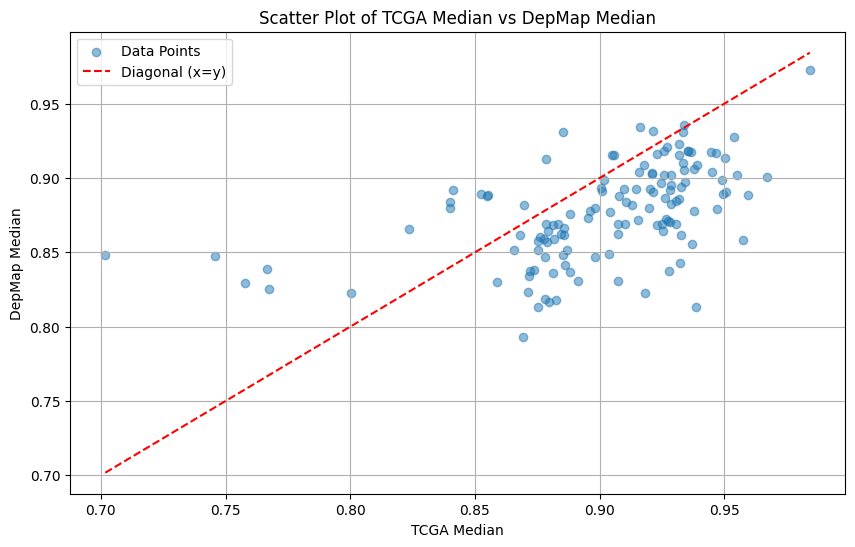

In [21]:
import matplotlib.pyplot as plt

# Assuming 'merge' is your DataFrame
x = merge['tcga_median']
y = merge['depmap_median']

plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, label='Data Points')

# Adding the diagonal line
plt.plot([min(x), max(x)], [min(x), max(x)], color='red', linestyle='--', label='Diagonal (x=y)')

plt.xlabel('TCGA Median')
plt.ylabel('DepMap Median')
plt.title('Scatter Plot of TCGA Median vs DepMap Median')
plt.grid(True)
plt.legend()
plt.show()


In [22]:
print(merge['tcga_median'].median())
print(merge['depmap_median'].median())

0.910450257951791
0.8796022763602219


In [23]:
merge[merge.depmap_median>0.88]['col1_new'].unique()


array(['Oligodendroglioma', 'Meningioma', 'Glioblastoma Multiforme',
       'Astrocytoma', 'Atypical Teratoid/Rhabdoid Tumor',
       'Acute Myeloid Leukemia', 'Acute Megakaryoblastic Leukemia',
       'Pleural Mesothelioma, Epithelioid Type',
       'Pleural Mesothelioma, Sarcomatoid Type',
       'Pleural Mesothelioma, Biphasic Type', 'Melanoma',
       'Cutaneous Melanoma', 'Leiomyosarcoma',
       'Undifferentiated Pleomorphic Sarcoma/Malignant Fibrous Histiocytoma/High-Grade Spindle Cell Sarcoma',
       'Myxofibrosarcoma', 'Desmoid/Aggressive Fibromatosis',
       'Dedifferentiated Liposarcoma', 'Embryonal Rhabdomyosarcoma',
       'Synovial Sarcoma', 'Alveolar Rhabdomyosarcoma',
       'Renal Clear Cell Carcinoma', "Wilms' Tumor",
       'Papillary Renal Cell Carcinoma', 'Hepatoblastoma',
       'Breast Invasive Lobular Carcinoma',
       'Breast Invasive Carcinoma, NOS', 'Serous Ovarian Cancer',
       'Poorly Differentiated Thyroid Cancer',
       'Follicular Thyroid Cancer', 

In [24]:
#depmap_corr=pd.read_csv('/Users/nabdirah/Project1/depmap_corr.csv')
dep_table=pd.read_csv('/Users/nabdirah/Project1/table_depmap_corr.csv')
dep_table

,Unnamed: 0,col1,col2,median_correlation,subtype,code,tissue,parent_col1,parent_col2
0,0,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
1,1,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
2,2,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
3,3,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
4,4,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
...,...,...,...,...,...,...,...,...,...
12345,12345,Glassy Cell Carcinoma of the Cervix,Mixed Cervical Carcinoma,0.898069,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN
12346,12346,Glassy Cell Carcinoma of the Cervix,Glassy Cell Carcinoma of the Cervix,NaN,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN
12347,12347,Mixed Cervical Carcinoma,Mixed Cervical Carcinoma,NaN,Mixed Cervical Carcinoma,MCCE,Cervix,NaN,NaN
12348,12348,NUT Midline Carcinoma of the Head and Neck,NUT Midline Carcinoma of the Head and Neck,NaN,NUT Midline Carcinoma of the Head and Neck,NMCHN,Head and Neck,NaN,NaN


In [25]:
# correlations for subtpes in depmap where one of the pairs exsists in tcga 
unique_depmap_corr

,depmap_median,col1_new,col2_new
0,0.848560,Medullary Thyroid Cancer,Follicular Thyroid Cancer
1,0.882244,Poorly Differentiated Thyroid Cancer,Follicular Thyroid Cancer
2,0.895285,Follicular Thyroid Cancer,Anaplastic Thyroid Cancer
3,0.879343,Papillary Thyroid Cancer,Follicular Thyroid Cancer
4,0.820025,Poorly Differentiated Thyroid Cancer,Medullary Thyroid Cancer
...,...,...,...
1024,0.930664,Retinoblastoma,Retinoblastoma
1025,0.912762,Teratoma,Embryonal Carcinoma (Testis)
1026,0.900908,Embryonal Carcinoma (Testis),Embryonal Carcinoma (Testis)
1027,0.915257,Teratoma,Teratoma


In [26]:
# Get the unique subtypes with high corr and have a correlation with a subtye in tcga 
high_corr_dep=unique_depmap_corr[unique_depmap_corr['depmap_median'] > 0.88][['col1_new', 'col2_new']].stack().unique()

In [27]:
#df: one of them is in tcga and has a high corr 
df=dep_table[(dep_table.col1.isin(high_corr_dep)| dep_table.col2.isin(high_corr_dep))
&((dep_table.col1!=dep_table.parent_col1 )|(dep_table.col2!=dep_table.parent_col2))] #one of them isn't in tcga 

df.to_csv('/Users/nabdirah/project1/one_of_them_is_in_tcga_and_has_a_high_corr.csv')

In [28]:
df

,Unnamed: 0,col1,col2,median_correlation,subtype,code,tissue,parent_col1,parent_col2
0,0,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
1,1,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
2,2,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
3,3,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
4,4,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer
...,...,...,...,...,...,...,...,...,...
12078,12078,AML with Minimal Differentiation,AML with Minimal Differentiation,0.898429,AML with Minimal Differentiation,AMLMD,Myeloid,Acute Megakaryoblastic Leukemia,Acute Megakaryoblastic Leukemia
12079,12079,Acute Leukemias of Ambiguous Lineage,Acute Leukemias of Ambiguous Lineage,0.946977,Acute Leukemias of Ambiguous Lineage,ALAL,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia
12080,12080,Acute Leukemias of Ambiguous Lineage,Acute Leukemias of Ambiguous Lineage,0.946977,Acute Leukemias of Ambiguous Lineage,ALAL,Myeloid,Acute Myeloid Leukemia,Acute Myeloid Leukemia
12278,12278,Signet Ring Cell Carcinoma of the Stomach,Small Cell Carcinoma of the Stomach,0.783986,Signet Ring Cell Carcinoma of the Stomach,SSRCC,Esophagus/Stomach,Signet Ring Cell Carcinoma of the Stomach,NaN


In [29]:
df_highcorr=df[df['median_correlation'] > 0.88][['col1', 'col2']].stack().unique()
notin_TCGA=np.setdiff1d(df_highcorr, tcga_meta[tcga_meta.derived_subtype.isin(df_highcorr)].derived_subtype.unique())
#these subtypes have a highcoreelation with a subtye in tcga_meta

In [30]:
'Anaplastic Thyroid Cancer' in notin_TCGA

True

In [31]:
import pandas as pd

def determine_closest_tcga(row, notin_TCGA):
    # Check if col1 is in notin_TCGA
    if row['col1'] in notin_TCGA:
        # If col1 is in notin_TCGA, use the value from col2
        return row['col2']
    # If col2 is in notin_TCGA, use the value from col1
    elif row['col2'] in notin_TCGA:
        return row['col1']
    # If neither col1 nor col2 is in notin_TCGA, return None
    return None

# Apply the function to each row in dep_table
dep_table['closest_tcga_subtype'] = dep_table.apply(lambda row: determine_closest_tcga(row, notin_TCGA), axis=1)

In [32]:
dep_table

,Unnamed: 0,col1,col2,median_correlation,subtype,code,tissue,parent_col1,parent_col2,closest_tcga_subtype
0,0,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
1,1,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
2,2,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
3,3,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
4,4,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
...,...,...,...,...,...,...,...,...,...,...
12345,12345,Glassy Cell Carcinoma of the Cervix,Mixed Cervical Carcinoma,0.898069,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN,None
12346,12346,Glassy Cell Carcinoma of the Cervix,Glassy Cell Carcinoma of the Cervix,NaN,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN,None
12347,12347,Mixed Cervical Carcinoma,Mixed Cervical Carcinoma,NaN,Mixed Cervical Carcinoma,MCCE,Cervix,NaN,NaN,None
12348,12348,NUT Midline Carcinoma of the Head and Neck,NUT Midline Carcinoma of the Head and Neck,NaN,NUT Midline Carcinoma of the Head and Neck,NMCHN,Head and Neck,NaN,NaN,None


In [33]:
'Giant Cell Tumor of Bone' in notin_TCGA

True

In [34]:
dep_table[dep_table.col1!=dep_table.col2].drop_duplicates().to_csv('/Users/nabdirah/Project1/closest_tcga.csv')

In [35]:
dep_table[dep_table.closest_tcga_subtype=='Giant Cell Tumor of Bone']

,Unnamed: 0,col1,col2,median_correlation,subtype,code,tissue,parent_col1,parent_col2,closest_tcga_subtype
227,227,Chondrosarcoma,Giant Cell Tumor of Bone,0.910390,Chondrosarcoma,CHS,Bone,Ewing Sarcoma,Ewing Sarcoma,Giant Cell Tumor of Bone
228,228,Chondrosarcoma,Giant Cell Tumor of Bone,0.910390,Chondrosarcoma,CHS,Bone,Ewing Sarcoma,Ewing Sarcoma,Giant Cell Tumor of Bone
353,353,Dedifferentiated Chondrosarcoma,Giant Cell Tumor of Bone,0.905951,Dedifferentiated Chondrosarcoma,DDCHS,Bone,NaN,Ewing Sarcoma,Giant Cell Tumor of Bone
354,354,Dedifferentiated Chondrosarcoma,Giant Cell Tumor of Bone,0.905951,Dedifferentiated Chondrosarcoma,DDCHS,Bone,NaN,Ewing Sarcoma,Giant Cell Tumor of Bone
423,423,Giant Cell Tumor of Bone,Giant Cell Tumor of Bone,NaN,Giant Cell Tumor of Bone,GCTB,Bone,Ewing Sarcoma,Ewing Sarcoma,Giant Cell Tumor of Bone


In [36]:
'Dedifferentiated Chondrosarcoma' in notin_TCGA

True

In [37]:
unique_depmap_corr[unique_depmap_corr.col1_new=='Giant Cell Tumor of Bone']

,depmap_median,col1_new,col2_new
23,0.910390,Giant Cell Tumor of Bone,Chondrosarcoma
27,0.829328,Giant Cell Tumor of Bone,Ewing Sarcoma
30,0.905951,Giant Cell Tumor of Bone,Dedifferentiated Chondrosarcoma
33,0.822305,Giant Cell Tumor of Bone,Extraskeletal Myxoid Chondrosarcoma
34,0.851356,Giant Cell Tumor of Bone,Chordoma
40,NaN,Giant Cell Tumor of Bone,Giant Cell Tumor of Bone


In [38]:
dep_table

,Unnamed: 0,col1,col2,median_correlation,subtype,code,tissue,parent_col1,parent_col2,closest_tcga_subtype
0,0,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
1,1,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
2,2,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
3,3,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
4,4,Follicular Thyroid Cancer,Medullary Thyroid Cancer,0.848560,Follicular Thyroid Cancer,THFO,Thyroid,Follicular Thyroid Cancer,Poorly Differentiated Thyroid Cancer,None
...,...,...,...,...,...,...,...,...,...,...
12345,12345,Glassy Cell Carcinoma of the Cervix,Mixed Cervical Carcinoma,0.898069,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN,None
12346,12346,Glassy Cell Carcinoma of the Cervix,Glassy Cell Carcinoma of the Cervix,NaN,Glassy Cell Carcinoma of the Cervix,CEGCC,Cervix,NaN,NaN,None
12347,12347,Mixed Cervical Carcinoma,Mixed Cervical Carcinoma,NaN,Mixed Cervical Carcinoma,MCCE,Cervix,NaN,NaN,None
12348,12348,NUT Midline Carcinoma of the Head and Neck,NUT Midline Carcinoma of the Head and Neck,NaN,NUT Midline Carcinoma of the Head and Neck,NMCHN,Head and Neck,NaN,NaN,None


In [39]:
dep_table.to_csv('/Users/nabdirah/Project1/depmap_table.csv')

In [40]:
unique_depmap_corr[unique_depmap_corr.col2_new=='Anaplastic Thyroid Cancer']

,depmap_median,col1_new,col2_new
2,0.895285,Follicular Thyroid Cancer,Anaplastic Thyroid Cancer
5,0.821113,Medullary Thyroid Cancer,Anaplastic Thyroid Cancer
7,0.878463,Poorly Differentiated Thyroid Cancer,Anaplastic Thyroid Cancer
9,0.883910,Papillary Thyroid Cancer,Anaplastic Thyroid Cancer
13,0.893065,Anaplastic Thyroid Cancer,Anaplastic Thyroid Cancer


In [41]:
dep_table['closest_tcga_subtype'].isna().mean()

0.31587044534412956

In [42]:
new_merged_cleaned.to_csv('/Users/nabdirah/Project1/tcga_dep_corr.csv')
new_merged.to_csv('/Users/nabdirah/Project1/All.csv')

NameError: name 'new_merged_cleaned' is not defined

In [ ]:
df_depmap['col1_new'] = df_depmap[['col1','col2']].max(axis=1) 
df_depmap['col2_new'] = df_depmap[['col1','col2']].min(axis=1)